#1 - Collaborative Filtering

In [2]:
import importlib, get_data, process_matches_and_members
importlib.reload(process_matches_and_members)

df_matches = get_data.get_dataframe_from_postgres("matches")
df_matches = process_matches_and_members.process_match_rating(df_matches)
df_members = get_data.get_dataframe_from_postgres("members")

In [3]:
import pandas as pd
# gives us a pd of all the matches where the woman was on YU connects,
# and cuts out all the match info except for the ids and is_good_match
yuconnects = pd.merge(df_matches, df_members[['id', 'site']],
                      left_on='female_id',
                      right_on='id',
                      how='left') \
                      [lambda x: x['site'] == 'YUConnects'] \
                      .drop(columns=['id_x', 'id_y']) #these columns get generated at some point, not sure why

In [7]:
from fastai.tabular.all import *

procs = [Categorify]
cat_names = ['male_id', 'female_id']
dep_var = ['is_good_match']
y_block = CategoryBlock()
splits = RandomSplitter(valid_pct=0.2)(range_of(yuconnects))

dls = TabularDataLoaders.from_df(
    yuconnects,
    path='.',
    procs=procs,
    cat_names=cat_names,
    cont_names=[],
    y_names=dep_var,
    y_block=y_block,
    splits=splits,
    bs=64
)

In [71]:
learn = tabular_learner(
    dls,
    metrics=accuracy
)
learn.fit_one_cycle(5, .01)
# ~74% accuracy

epoch,train_loss,valid_loss,accuracy,time
0,0.529265,0.558147,0.723768,00:11
1,0.495763,0.544611,0.734185,00:10
2,0.481634,0.531893,0.740116,00:10
3,0.448142,0.536375,0.740154,00:10
4,0.451939,0.540190,0.740268,00:10


In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds, targs = learn.get_preds()
predicted_classes = torch.argmax(preds, dim=1)

class_names = ['Bad Match', 'Good Match']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=targs,
    y_pred=predicted_classes,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

NameError: name 'learn' is not defined

#2 Random Forest Model

In [10]:
# this is a nested merge that gets all the data about the males and females in a match
yuconnects_with_member_data = yuconnects.merge(df_members.add_prefix('female_'),
                                               left_on='female_id',
                                               right_on='female_id',
                                               how='left',
                                               suffixes=('', '_female_y')).merge(
                                                   df_members.add_prefix('male_'),
                                                   left_on='male_id',
                                                   right_on='male_id',
                                                   how='left',
                                                   suffixes=('_female', '_male')
                                               )


In [11]:
column_names = yuconnects_with_member_data.columns

# all the continuous columns with operating data (some seemingly continuous columns have bad data)
forest_cont_names = ['female_age', 'female_height_inches', 'female_num_matches',
                     'female_acceptance_rate', 'female_min_height_inches', 'female_max_height_inches',
                     'male_age', 'male_height_inches', 'male_num_matches',
                     'male_acceptance_rate', 'male_min_height_inches', 'male_max_height_inches']

# these are columns that are used to calculate 'is_good_match' and must be kept hidden from the model
indicators_of_dep_var = [
                         'ms','male_pr', 'male_s','female_s',
                         'female_pr', 'matchmaker_pr', 'match_quality',
                         'decline_reason','overall_pr','male_s_rating',
                         'female_s_rating', 'quality_rating','overall_rating',
                         ]
# all columns that aren't continuous are categorical
forest_cat_names = [col for col in column_names if col not in forest_cont_names and col not in indicators_of_dep_var and col not in dep_var]

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# We are adding to the procs FillMissing, because whereas before there were no missing values, now there are.
# We are also adding normalize which will normalize the values in our columns with continuous values
procs = [Categorify, Normalize, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(yuconnects_with_member_data))

to = TabularPandas(yuconnects_with_member_data,
                   procs=procs,
                   cat_names=forest_cat_names,
                   cont_names=forest_cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block=CategoryBlock())
X_train = to.train.xs
y_train = to.train.y
X_valid = to.valid.xs
y_valid = to.valid.y

/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [76]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)

y_pred_valid = rf_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Accuracy: {accuracy}")
# 75% accuracy

Accuracy: 0.7525091240875912


In [77]:
X_train.columns.tolist()
# male_pr, ms,

['male_id',
 'female_id',
 'site',
 'female_country',
 'female_city',
 'female_state',
 'female_gender',
 'female_religious_orientation',
 'female_ethnicity',
 'female_baal_teshuva',
 'female_years_orthodox_baal_teshuva',
 'female_cohen',
 'female_female_convert',
 'female_parents_convert',
 'female_mother_maternal_grandmother_jewish',
 'female_family_religious_background',
 'female_describe_family_religious_background',
 'female_female_hc',
 'female_kosher',
 'female_female_dress',
 'female_male_hc',
 'female_frequency_of_tefilah',
 'female_male_shul_attendance',
 'female_torah_study',
 'female_watching_tv',
 'female_going_out_to_movies',
 'female_watching_movies_at_home',
 'female_secular_education',
 'female_emphasis_of_studies',
 'female_jewish_education',
 'female_study_in_israel',
 'female_profession',
 'female_job_description',
 'female_eye_color',
 'female_hair_color',
 'female_height',
 'female_body_type',
 'female_mental_physical_disability',
 'female_my_marriage_status',
 'f

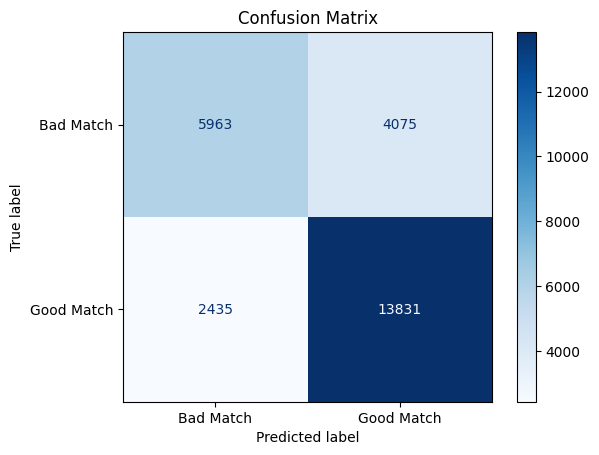

In [78]:
class_names = ['Bad Match', 'Good Match']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

In [13]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators= 100,
    learning_rate=.1,
    max_depth=20,
    enable_categorical=True,
    subsample=1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_valid = xgb_model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Accuracy: {accuracy}")
# ~76.5% accuracy (playing with hyperparams didn't change much as long as max_depth was above 20)

/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7662712895377128


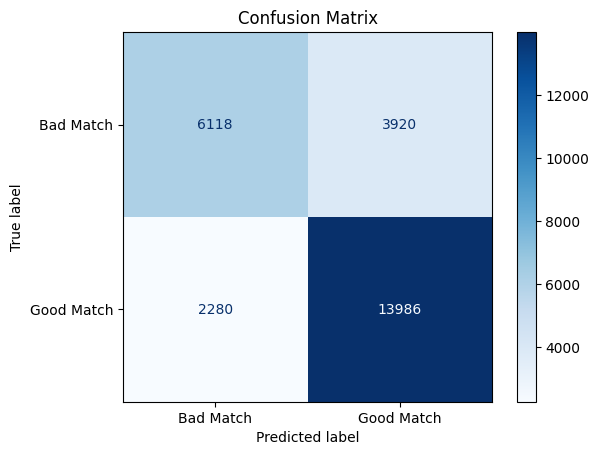

In [80]:
class_names = ['Bad Match', 'Good Match']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

#2a - Random Forest with Rejection Counts

In [14]:
import importlib
import rejection_type_counts
importlib.reload(rejection_type_counts)
members_with_matches = df_members[df_members['num_matches'] > 0]
rejection_count = rejection_type_counts.add_rejection_type_counts(members_with_matches, df_matches)

In [15]:
# this is a nested merge that gets all the data about the males and females in a match
yuconnects_with_rejection_count = yuconnects.merge(rejection_count.add_prefix('female_'),
                                               left_on='female_id',
                                               right_on='female_id',
                                               how='left',
                                               suffixes=('', '_female_y')).merge(
                                                   rejection_count.add_prefix('male_'),
                                                   left_on='male_id',
                                                   right_on='male_id',
                                                   how='left',
                                                   suffixes=('_female', '_male')
                                               )
# gets rid of bad values that allow for more continuous columns
yuconnects_with_rejection_count = process_matches_and_members.process_data(yuconnects_with_rejection_count)

In [16]:
column_names = yuconnects_with_rejection_count.columns

# all the rejection count columns
rejection_counts_columns = [col for col in column_names if col.startswith('male_male_reason')
                                                or col.startswith('male_male_rejection')
                                                or col.startswith('female_female_reason')
                                                or col.startswith('female_female_rejection')]

# all the continuous columns with operating data (some seemingly continuous columns have bad data)
forest_cont_names = rejection_counts_columns +  ['female_age', 'female_height_inches', 'female_num_matches',
                     'female_acceptance_rate', 'female_min_height_inches', 'female_max_height_inches',
                     'male_age', 'male_height_inches', 'male_num_matches',
                     'male_acceptance_rate', 'male_min_height_inches', 'male_max_height_inches']

# all columns that aren't continuous are categorical
forest_cat_names = [col for col in column_names if col not in forest_cont_names and col not in indicators_of_dep_var and col not in dep_var]

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# We are adding to the procs FillMissing, because whereas before there were no missing values, now there are.
# We are also adding normalize which will normalize the values in our columns with continuous values
procs = [Categorify, Normalize, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(yuconnects_with_rejection_count))
to = TabularPandas(yuconnects_with_rejection_count,
                   procs=procs,
                   cat_names=forest_cat_names,
                   cont_names=forest_cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block=CategoryBlock())
X_train = to.train.xs
y_train = to.train.y
X_valid = to.valid.xs
y_valid = to.valid.y

/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fill

In [85]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)

y_pred_valid = rf_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Accuracy: {accuracy}")
# 77% accuracy

Accuracy: 0.7722019464720195


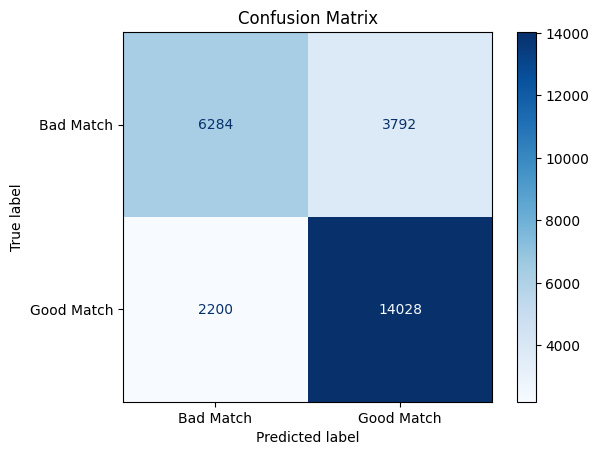

In [86]:
class_names = ['Bad Match', 'Good Match']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

#2b - More Rejection Feature Engineering

In [17]:
importlib.reload(rejection_type_counts)
members_with_matches = df_members[df_members['num_matches'] > 0]
rejection_count = rejection_type_counts.add_rejection_sums(rejection_count, df_matches)

/Users/jackwarren/Documents/1 Projects/YU Summer Program/SYAS Work/AIGroup/fastai/models/rejection_type_counts.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_members['rejecter_count'].fillna(0, inplace=True)
/Users/jackwarren/Documents/1 Projects/YU Summer Program/SYAS Work/AIGroup/fastai/models/rejection_type_counts.py:130: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will 

In [18]:
mean_acceptance_rate = rejection_count['acceptance_rate'].mean()
rejection_count['acceptance_rate'].fillna(mean_acceptance_rate, inplace=True)

/var/folders/t9/qgftbn5n1q57fwq_6fy36gm80000gn/T/ipykernel_70838/313136462.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rejection_count['acceptance_rate'].fillna(mean_acceptance_rate, inplace=True)


In [19]:
# this is a nested merge that gets all the data about the males and females in a match
yuconnects_with_rejection_count = yuconnects.merge(rejection_count.add_prefix('female_'),
                                               left_on='female_id',
                                               right_on='female_id',
                                               how='left',
                                               suffixes=('', '_female_y')).merge(
                                                   rejection_count.add_prefix('male_'),
                                                   left_on='male_id',
                                                   right_on='male_id',
                                                   how='left',
                                                   suffixes=('_female', '_male')
                                               )

In [20]:
yuconnects_with_rejection_count = rejection_type_counts.add_rejection_products(yuconnects_with_rejection_count)
yuconnects_with_rejection_count['male_percent_rejected'].fillna(0, inplace=True)
yuconnects_with_rejection_count['male_percent_rejecter'].fillna(0, inplace=True)

/var/folders/t9/qgftbn5n1q57fwq_6fy36gm80000gn/T/ipykernel_70838/3826521175.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  yuconnects_with_rejection_count['male_percent_rejected'].fillna(0, inplace=True)
/var/folders/t9/qgftbn5n1q57fwq_6fy36gm80000gn/T/ipykernel_70838/3826521175.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

<Axes: ylabel='Density'>

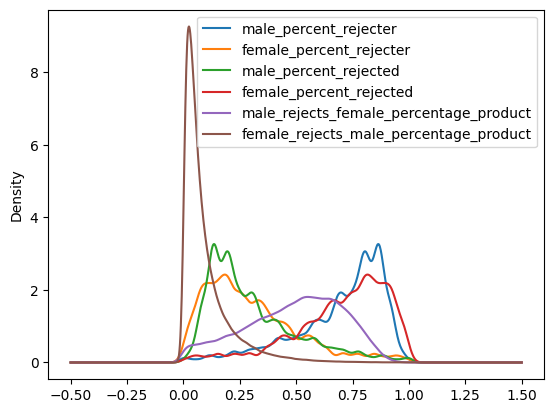

In [32]:
yuconnects_with_rejection_count[['male_percent_rejecter', 'female_percent_rejecter', 'male_percent_rejected', 'female_percent_rejected']]
yuconnects_with_rejection_count['male_rejects_female_percentage_product'] = yuconnects_with_rejection_count['male_percent_rejecter'] * yuconnects_with_rejection_count['female_percent_rejected']
yuconnects_with_rejection_count['female_rejects_male_percentage_product'] = yuconnects_with_rejection_count['female_percent_rejecter'] * yuconnects_with_rejection_count['male_percent_rejected']
yuconnects_with_rejection_count[['male_percent_rejecter', 'female_percent_rejecter', 'male_percent_rejected', 'female_percent_rejected', 'male_rejects_female_percentage_product', 'female_rejects_male_percentage_product']].plot.kde()

In [33]:
procs = [Categorify, Normalize, FillMissing]

column_names = yuconnects_with_rejection_count.columns

product_columns = [col for col in column_names if 'product' in col]

# rejectered is combo of 'rejecter' and 'rejected' (both of which contain 'rejecte')
rejectered_columns = [col for col in column_names if 'rejecte' in col]

forest_cont_names = forest_cont_names + product_columns + rejectered_columns

forest_cat_names = [col for col in column_names if (col not in forest_cont_names) and (col not in indicators_of_dep_var) and (col not in dep_var)]

splits = RandomSplitter(valid_pct=0.2)(range_of(yuconnects_with_rejection_count))
forest_cat_names


['male_id',
 'female_id',
 'site',
 'female_country',
 'female_city',
 'female_state',
 'female_gender',
 'female_religious_orientation',
 'female_ethnicity',
 'female_baal_teshuva',
 'female_years_orthodox_baal_teshuva',
 'female_cohen',
 'female_female_convert',
 'female_parents_convert',
 'female_mother_maternal_grandmother_jewish',
 'female_family_religious_background',
 'female_describe_family_religious_background',
 'female_female_hc',
 'female_kosher',
 'female_female_dress',
 'female_male_hc',
 'female_frequency_of_tefilah',
 'female_male_shul_attendance',
 'female_torah_study',
 'female_watching_tv',
 'female_going_out_to_movies',
 'female_watching_movies_at_home',
 'female_secular_education',
 'female_emphasis_of_studies',
 'female_jewish_education',
 'female_study_in_israel',
 'female_profession',
 'female_job_description',
 'female_eye_color',
 'female_hair_color',
 'female_height',
 'female_body_type',
 'female_mental_physical_disability',
 'female_my_marriage_status',
 'f

In [34]:
to = TabularPandas(yuconnects_with_rejection_count,
                   procs=procs,
                   cat_names=forest_cat_names,
                   cont_names=forest_cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block=CategoryBlock())
X_train = to.train.xs
y_train = to.train.y
X_valid = to.valid.xs
y_valid = to.valid.y

/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fill

In [35]:
len(to.train.xs.columns.tolist())

626

In [36]:
X_train['male_rejects_female_percentage_product']

8267      0.556744
95596     0.781757
101297   -1.574982
125064    0.177006
128929    0.234556
            ...   
76456     0.477966
93951    -2.059916
104843    1.622372
101084   -0.424916
30595    -0.497562
Name: male_rejects_female_percentage_product, Length: 105216, dtype: float64

In [141]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)

y_pred_valid = rf_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Accuracy: {accuracy}")
# 78% accuracy

Accuracy: 0.7777904501216545


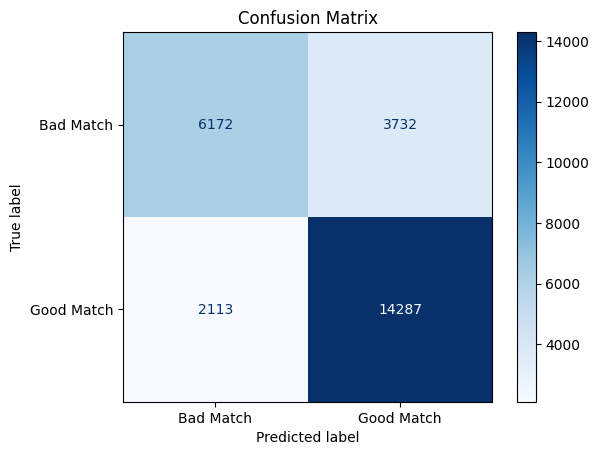

In [142]:
class_names = ['Bad Match', 'Good Match']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

#2c - throwing it in an XGBoost Model

In [41]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators= 250,
    learning_rate=.1,
    max_depth=25,
    enable_categorical=True,
    subsample=1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_valid = xgb_model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Accuracy: {accuracy}")
# ~79% accuracy (playing with hyperparams didn't change much as long as max_depth was above 20)

/Users/jackwarren/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7893856447688564


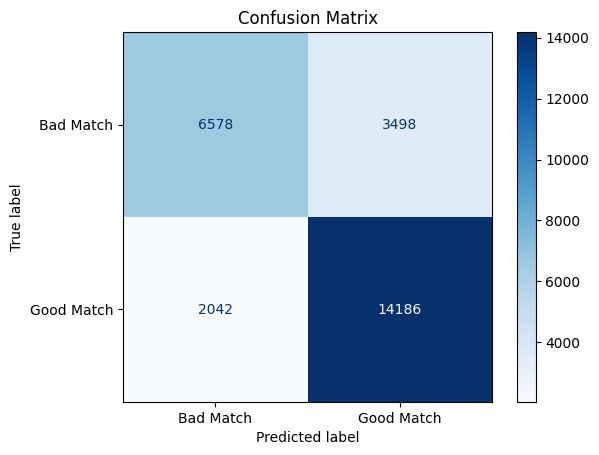

In [61]:
class_names = ['Bad Match', 'Good Match']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

In [85]:
y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
# best accuracy
y_pred_very_strict = (y_pred_proba >= 0.65).astype(int)
y_pred_strict = (y_pred_proba >= 0.565).astype(int)

# You can then evaluate accuracy or other metrics with these new predictions
from sklearn.metrics import accuracy_score
print(f"Accuracy (strict): {accuracy_score(y_valid, y_pred_very_strict)}")
print(f"Accuracy (lenient): {accuracy_score(y_valid, y_pred_strict)}")

Accuracy (strict): 0.7900699513381995
Accuracy (lenient): 0.7907922749391727


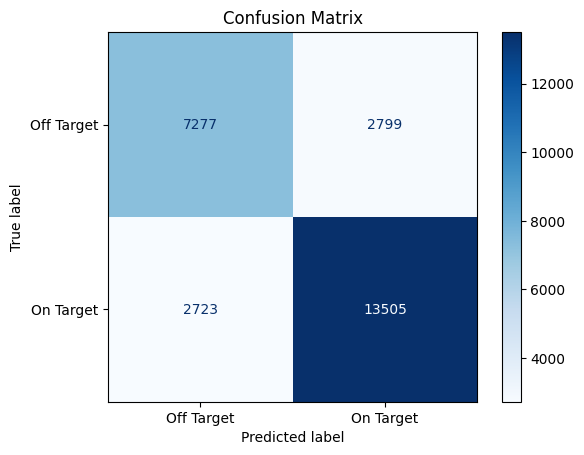

In [86]:
class_names = ['Off Target', 'On Target']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_very_strict,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix")
plt.show()

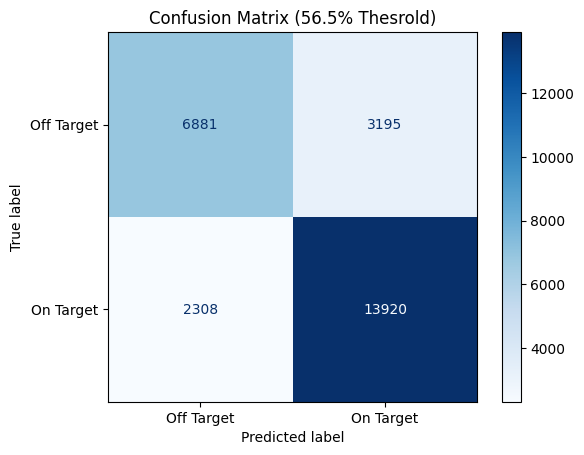

In [99]:
class_names = ['Off Target', 'On Target']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_strict,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix (56.5% Thesrold)")
plt.show()

In [113]:
y_pred_lenient = (y_pred_proba >= 0.1).astype(int)
print(f"Accuracy (lenient): {accuracy_score(y_valid, y_pred_lenient)}")

Accuracy (lenient): 0.7409899635036497


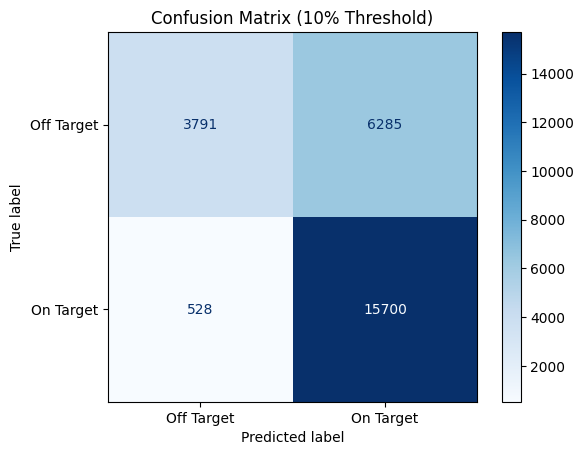

In [112]:
class_names = ['Off Target', 'On Target']

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid,
    y_pred=y_pred_lenient,
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix (10% Threshold)")
plt.show()